In [147]:
import dbnomics
import janitor
from autoIG.utils import display_df
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdate

import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(module)-20s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)


In [148]:
# Inflation rates
inflation_raw = dbnomics.fetch_series(
    provider_code="ONS", dataset_code="MM23", series_code="L55O.M"
)
print(inflation_raw.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   @frequency       905 non-null    object        
 1   provider_code    905 non-null    object        
 2   dataset_code     905 non-null    object        
 3   dataset_name     905 non-null    object        
 4   series_code      905 non-null    object        
 5   series_name      905 non-null    object        
 6   original_period  905 non-null    object        
 7   period           905 non-null    datetime64[ns]
 8   original_value   905 non-null    object        
 9   value            406 non-null    float64       
 10  title            905 non-null    object        
 11  freq             905 non-null    object        
 12  Title            905 non-null    object        
 13  Frequency        905 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1

In [162]:
inflation = inflation_raw.pipe(janitor.clean_names).rename_column('value','inflation')
inflation = inflation.set_index("period").pipe(display_df)

,@frequency,provider_code,dataset_code,dataset_name,series_code,series_name,original_period,original_value,inflation,title,freq,title,frequency
period,,,,,,,,,,,,,
1947-06-01,monthly,ONS,MM23,Consumer price inflation time series,L55O.M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100 – Monthly,1947-06,NA,NaN,L55O,M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100,Monthly


In [234]:
inflation = inflation[~inflation['inflation'].isna()]
inflation = inflation[['inflation']]

In [164]:
inflation_interpolated = inflation.resample('D').interpolate(method = 'linear')

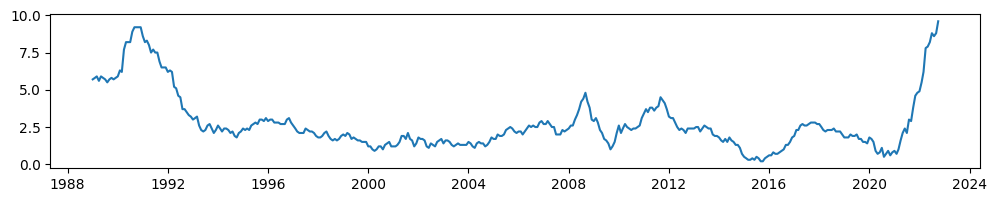

In [166]:
fig,ax = plt.subplots()
ax.plot(inflation.inflation)
fig.set_size_inches(12,2)

In [153]:
# Interest rates
base_rate = pd.read_csv("../../resources/Bank Rate history and data  Bank of England Database.csv")
base_rate = base_rate.pipe(janitor.clean_names).pipe(display_df,n=3)
base_rate['date_changed']= pd.to_datetime(base_rate.date_changed)
print(base_rate.describe())
base_rate=base_rate.set_index('date_changed')

,date_changed,rate
0,03 Nov 22,3.00
1,22 Sep 22,2.25
2,04 Aug 22,1.75


             rate
count  246.000000
mean     9.155407
std      3.739537
min      0.100000
25%      6.160000
50%      9.880000
75%     11.880000
max     17.000000


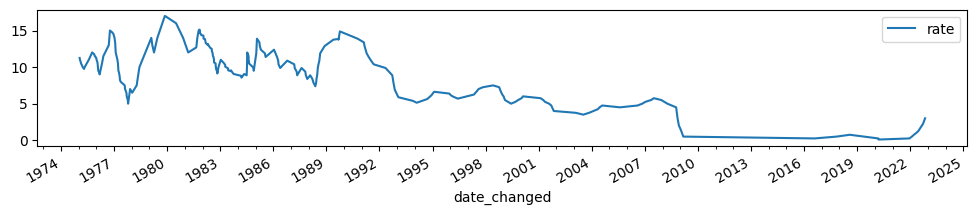

In [154]:
base_rate.plot(figsize = (12,2))
plt.gca().xaxis.set_minor_locator(mdate.MonthLocator(1))
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdate.YearLocator(3))

In [155]:
base_rate_interpolated = (
    base_rate.resample("D")
    .asfreq()
    .pipe(display_df, n=10)
    .interpolate(method="linear")
    .pipe(display_df, n=10)
)


,rate
date_changed,
1975-01-20,11.25
1975-01-21,NaN
1975-01-22,NaN
1975-01-23,NaN
1975-01-24,NaN
1975-01-25,NaN
1975-01-26,NaN
1975-01-27,11.00
1975-01-28,NaN


,rate
date_changed,
1975-01-20,11.250000
1975-01-21,11.214286
1975-01-22,11.178571
1975-01-23,11.142857
1975-01-24,11.107143
1975-01-25,11.071429
1975-01-26,11.035714
1975-01-27,11.000000
1975-01-28,10.982143


In [156]:
lower_bound = max(inflation_interpolated.index.min(),base_rate_interpolated.index.min())
upper_bound = min(inflation_interpolated.index.max(),base_rate_interpolated.index.max())
logging.info(f'Lowerbound: {lower_bound}')
logging.info(f'Upperbound: {upper_bound}')


2022-11-20 16:08:23 INFO     2353818707           Lowerbound: 1989-01-01 00:00:00
2022-11-20 16:08:23 INFO     2353818707           Upperbound: 2022-10-01 00:00:00


In [175]:
similarity_index = base_rate_interpolated.join(inflation_interpolated)[
    ["rate", "inflation"]
]
similarity_index = similarity_index[
    (similarity_index.index > lower_bound) & (similarity_index.index < upper_bound)
]


In [176]:
# from sklearn.preprocessing import StandardScaler
# similarity_index_scaled = pd.DataFrame(StandardScaler().fit_transform(X= similarity_index), index = similarity_index.index,columns = similarity_index.columns )
from scipy import stats
similarity_index['rate_scaled'] = stats.zscore(similarity_index.rate)
similarity_index['inflation_scaled'] = stats.zscore(similarity_index.inflation)

In [187]:
SIMILARITY_TO = '2022-08-31' # The date we want to compare to
current_values = similarity_index[similarity_index.index == SIMILARITY_TO]
similarity_index['current_inflation_scaled'] = float(current_values.inflation_scaled)
similarity_index['current_rate_scaled'] = float(current_values.rate_scaled)
similarity_index

,rate,inflation,rate_scaled,inflation_scaled,overall_similarity,rate_similarity,inflation_similarity,current_inflation_scaled,current_rate_scaled
date_changed,,,,,,,,,
1989-01-02,13.062652,5.703226,2.315509,1.597549,4.504816,2.859065,1.645752,3.243301,-0.543556
1989-01-03,13.067459,5.706452,2.316754,1.599267,4.504344,2.860310,1.644034,3.243301,-0.543556
1989-01-04,13.072265,5.709677,2.317999,1.600985,4.503871,2.861555,1.642316,3.243301,-0.543556
1989-01-05,13.077072,5.712903,2.319244,1.602703,4.503398,2.862800,1.640598,3.243301,-0.543556
1989-01-06,13.081878,5.716129,2.320490,1.604421,4.502925,2.864045,1.638880,3.243301,-0.543556
...,...,...,...,...,...,...,...,...,...
2022-09-26,2.321429,9.466667,-0.466901,3.601770,0.435124,0.076655,0.358469,3.243301,-0.543556
2022-09-27,2.339286,9.493333,-0.462275,3.615971,0.453951,0.081281,0.372671,3.243301,-0.543556
2022-09-28,2.357143,9.520000,-0.457650,3.630172,0.472778,0.085906,0.386872,3.243301,-0.543556


In [185]:
similarity_index["rate_similarity"] = (
    current_rate_scaled - similarity_index["rate_scaled"]
).abs()
similarity_index["inflation_similarity"] = (
    current_inflation_scaled - similarity_index["inflation_scaled"]
).abs()

similarity_index['overall_similarity'] = similarity_index["rate_similarity"] + similarity_index["inflation_similarity"]

similarity_index.sort_values("overall_similarity", ascending=False)


,rate,inflation,rate_scaled,inflation_scaled,overall_similarity,rate_similarity,inflation_similarity
date_changed,,,,,,,
2000-04-01,5.964973,0.900000,0.476924,-0.960409,5.224189,1.020480,4.203710
2000-03-31,5.965659,0.903226,0.477102,-0.958691,5.222649,1.020658,4.201992
2000-04-02,5.964286,0.903333,0.476746,-0.958634,5.222236,1.020302,4.201935
2000-03-30,5.966346,0.906452,0.477280,-0.956973,5.221109,1.020835,4.200274
2000-04-03,5.963599,0.906667,0.476568,-0.956859,5.220283,1.020124,4.200159
...,...,...,...,...,...,...,...
2022-08-28,1.994898,8.774194,-0.551486,3.232993,0.018237,0.007930,0.010307
2022-08-29,2.005102,8.780645,-0.548842,3.236429,0.012158,0.005287,0.006872
2022-08-30,2.015306,8.787097,-0.546199,3.239865,0.006079,0.002643,0.003436


<AxesSubplot: xlabel='date_changed'>

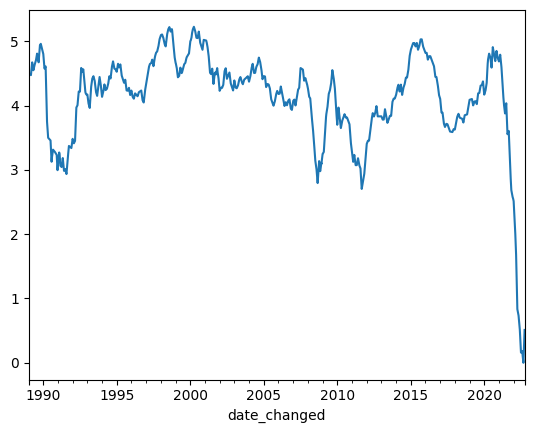

In [189]:
similarity_index.overall_similarity.plot()

In [190]:
## Get better inflation data. 

In [222]:
inflation_1950_1988 = pd.read_excel('publicationtablesdataset.xlsx',sheet_name='Table 6',skiprows=3)
inflation_1950_1988 = inflation_1950_1988[1:]
inflation_1950_1988 = inflation_1950_1988.iloc[:,[0,2]]
inflation_1950_1988.columns = ['period','inflation']
inflation_1950_1988


,period,cpi_percentage_change_over_12_months
1,Jan 1949,[No data]
2,Feb 1949,[No data]
3,Mar 1949,[No data]
4,Apr 1949,[No data]
5,May1949,[No data]
...,...,...
476,Aug 1988,4.4
477,Sep 1988,4.6
478,Oct 1988,4.7
479,Nov 1988,4.6


In [224]:
inflation_1950_1988.period = pd.to_datetime(inflation_1950_1988.period)
inflation_1950_1988 = inflation_1950_1988.set_index('period')


In [227]:
import numpy as np

inflation_1950_1988.cpi_percentage_change_over_12_months = np.where(
    inflation_1950_1988.cpi_percentage_change_over_12_months == "[No data]",
    np.nan,
    inflation_1950_1988.cpi_percentage_change_over_12_months,
).astype(float)



In [231]:
inflation.head()

,@frequency,provider_code,dataset_code,dataset_name,series_code,series_name,original_period,original_value,inflation,title,freq,title,frequency
period,,,,,,,,,,,,,
1989-01-01,monthly,ONS,MM23,Consumer price inflation time series,L55O.M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100 – Monthly,1989-01,5.7,5.7,L55O,M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100,Monthly
1989-02-01,monthly,ONS,MM23,Consumer price inflation time series,L55O.M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100 – Monthly,1989-02,5.8,5.8,L55O,M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100,Monthly
1989-03-01,monthly,ONS,MM23,Consumer price inflation time series,L55O.M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100 – Monthly,1989-03,5.9,5.9,L55O,M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100,Monthly
1989-04-01,monthly,ONS,MM23,Consumer price inflation time series,L55O.M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100 – Monthly,1989-04,5.6,5.6,L55O,M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100,Monthly
1989-05-01,monthly,ONS,MM23,Consumer price inflation time series,L55O.M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100 – Monthly,1989-05,5.9,5.9,L55O,M,CPIH ANNUAL RATE 00: ALL ITEMS 2015=100,Monthly


In [230]:
inflation_1950_1988.tail()

,cpi_percentage_change_over_12_months
period,
1988-08-01,4.4
1988-09-01,4.6
1988-10-01,4.7
1988-11-01,4.6
1988-12-01,4.7
